# Convolutional Neural Network

Today we are are implementing a convolutional neural network for image classification based on the `CIFAR-10` dataset. The `CIFAR-10` dataset is an image dataset with 10 classes, such as airplanes, cars, birds, cats, etc. This dataset is directly available in `pytorch`. We will create a convolutional neural network in `pytorch` to classify these images.

Let's talk about convolutional neural networks very briefly. They are similar to ordinary neural networks; they are made up or neurons with learnable weights and biases. Convolution neural networks mainly work with image data and apply a convolutional filter. We have convolutional layers, optional activation functions, and pooling layers. These layers are used to automatically learn some features from the images. At the end, we have a one or more fully connected layers for the classification class. 

Below is the typical architecture of a CNN.

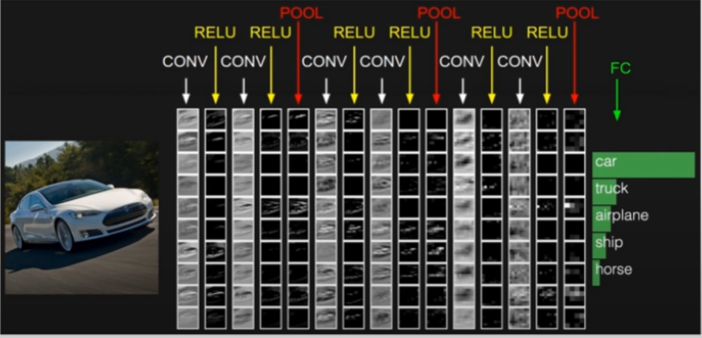

The convolutional filters operate by applying a filter kernel to our image. 

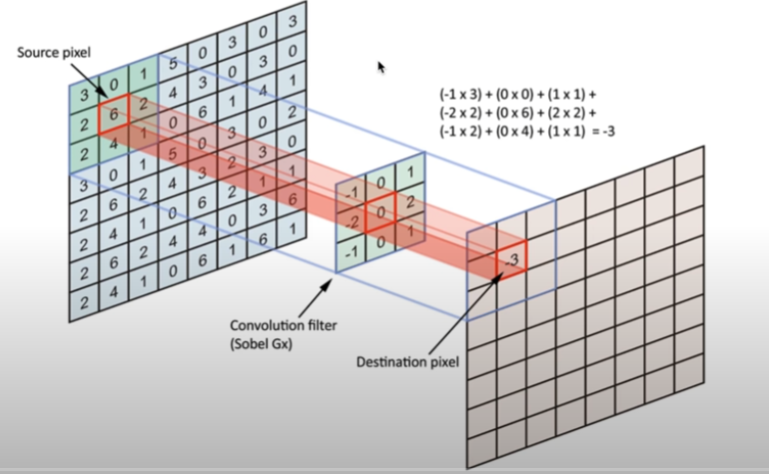

We put the filter at the first position (red) in our image and we compute the output by multiplying and summing up all the values. We then write the value to the output image. Then we slide our position to the next position (green) and apply the same filter operation. We slide it over the whole image until we finish.

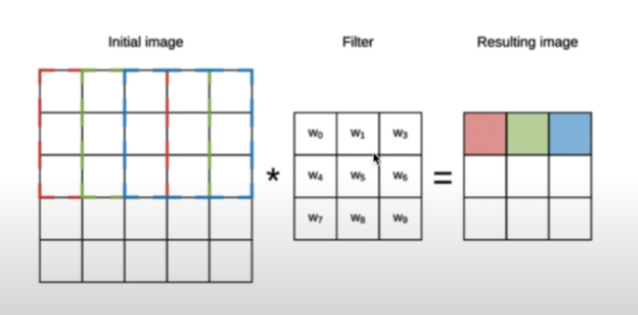

With this transform, our image may be a smaller since the filter does fit in the corners, except if we use a techniqued called padding, which will not be covered here. 

Then we also have pooling layers. 

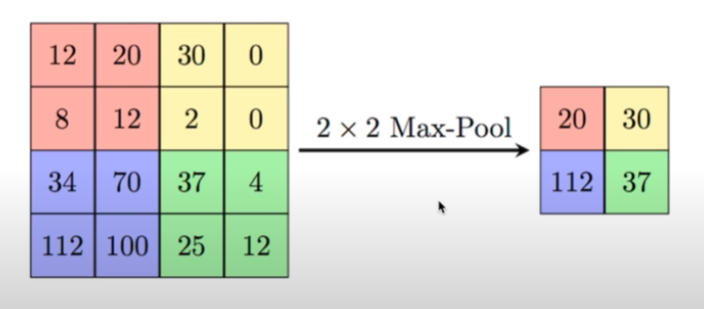

Pooling layers, more specific max pooling, is used to down sample an image by applying a maximum filter to subregions. Above, we have a filter of size 2x2. We look at the 2x2 subregions (red, yellow, blue, green) and write the maximum value of the region to the output region. It is used to reduce the computational cost by reducing the size of the image. This reduces the number of parameters the model has to learn and it prevents overfitting. 

As with the previous tutorial, we will follow the same steps:


* Loading the MNIST data
* DataLoader and Transformation
* Multilayer Neural Net, Activation Function
* Loss and Optimizer
* Training Loop (Batch Training)
* Model Evaluation - Calculating Accuracy
* GPU Support 

Now, let's import our modules. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Now for device configuration. It will be GPU if we have CUDA or CPU if not.

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Now, we will define our hyperparameters.

In [3]:
# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

Then we load the dataset and define the classes. 

In [4]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#making data loaders, which will allow us to automatically do batch training 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

#define the classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We can now write some code to take a look attake a look at some sample images.

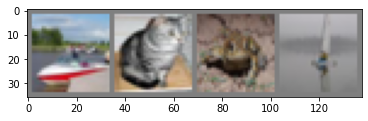

In [7]:
#defining the function
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

Now we have to implement the convolution neural network. Our CNN will look like: 

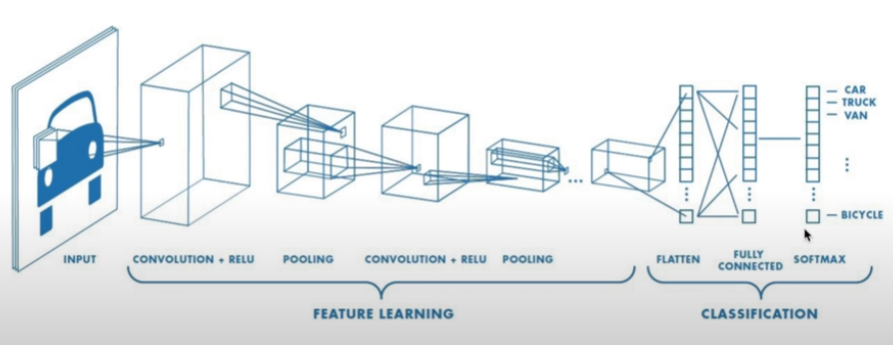

Our images are 32x32. Our batch size is 4 and we have 3 different color channels. This is the original size of the images: (4, 3, 32, 32). When we apply the first convolutional layer, the size of our images is (4, 6, 28, 28); the resulting image may be smaller because it does not fit in the corners. After the pooling layer, the size is (4, 6, 14, 14); this is because our pooling layer with a kernel of size 2x2 and stride of 2, the images will be reduced by a factor of 2. After the second convolutional layer, the sizes are (4, 16, 10, 10). In the final pooling operation, which will reduce the size by a factor of 2, the sizes are (4, 16, 5, 5); this is the final size after applying 2 convolutional filters and pooling layers. 

When we put the convolution layers into the classification layers, we want to flatten to size; a 3D tensor to a 1D tensor. 

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #the input channel size is 3 because our images have 3 color channels
        #the output channel size is 6 and the kernel size is 5 (5x5) 
        self.pool = nn.MaxPool2d(2, 2) #kernel size of 2 and stride of 2 - same as the max pooling image 
        #after each operation, we shift it 2 pixels to the right 
        self.conv2 = nn.Conv2d(6, 16, 5) #the input channel size must be equal to the last output channel size (6)
        
        #next is the fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10) #output is 10 for 10 different classes - this will be fixed
        #the 120 and 84 can be changed, but 10 and 16*5*5 must be fixed
        
    #forward pass
    def forward(self, x):
        # first activation function, first convolution layer, and first pooling 
        x = self.pool(F.relu(self.conv1(x))) #the activation function does not change the size
        # second activation function, second convolution layer, and second pooling 
        x = self.pool(F.relu(self.conv2(x)))
        
        #now we must pass it to the fully connected layer, but first we must flatten it
        x = x.view(-1, 16 * 5 * 5)
        
        x = F.relu(self.fc1(x))    #activation function
        x = F.relu(self.fc2(x))    #activation function4
        x = self.fc3(x)            #no activation function at the end and no softmax because it will be in the loss
        return x

Now, to create our model.

In [22]:
#now, we to create our model
model = ConvNet().to(device)

Now, we can define the loss and select the optimizer.

In [23]:
#loss
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Creating the training loop.

In [24]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/5], Step [2000/12500], Loss: 2.3087
Epoch [1/5], Step [4000/12500], Loss: 2.3181
Epoch [1/5], Step [6000/12500], Loss: 2.2959
Epoch [1/5], Step [8000/12500], Loss: 2.2923
Epoch [1/5], Step [10000/12500], Loss: 2.2934
Epoch [1/5], Step [12000/12500], Loss: 2.2706
Epoch [2/5], Step [2000/12500], Loss: 2.1573
Epoch [2/5], Step [4000/12500], Loss: 2.0435
Epoch [2/5], Step [6000/12500], Loss: 2.0257
Epoch [2/5], Step [8000/12500], Loss: 1.9148
Epoch [2/5], Step [10000/12500], Loss: 1.7049
Epoch [2/5], Step [12000/12500], Loss: 1.7487
Epoch [3/5], Step [2000/12500], Loss: 1.6439
Epoch [3/5], Step [4000/12500], Loss: 1.8171
Epoch [3/5], Step [6000/12500], Loss: 1.7162
Epoch [3/5], Step [8000/12500], Loss: 1.6252
Epoch [3/5], Step [10000/12500], Loss: 1.9962
Epoch [3/5], Step [12000/12500], Loss: 1.9383
Epoch [4/5], Step [2000/12500], Loss: 1.7278
Epoch [4/5], Step [4000/12500], Loss: 1.6216
Epoch [4/5], Step [6000/12500], Loss: 1.7712
Epoch [4/5], Step [8000/12500], Loss: 1.1295
Epoc

Now to apply our model to the testing data and calculate the accuracy.

In [25]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 48.53 %
Accuracy of plane: 58.3 %
Accuracy of car: 64.9 %
Accuracy of bird: 28.8 %
Accuracy of cat: 14.5 %
Accuracy of deer: 39.3 %
Accuracy of dog: 43.5 %
Accuracy of frog: 59.0 %
Accuracy of horse: 68.1 %
Accuracy of ship: 54.1 %
Accuracy of truck: 54.8 %
